## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusion)


<a id='intro'></a>
### Introduction

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  
Our goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, reading in the `ab_data.csv` data.

a. Reading in the dataset and taking a look at the top few rows here:

In [3]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. The number of rows in the dataset.

In [100]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [101]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [102]:
df.query("converted==1").user_id.nunique()/df.user_id.nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't match.

In [103]:
combination_one=df.query("group=='treatment' and landing_page=='old_page'")
combination_two=df.query("group=='control' and landing_page=='new_page'")
total=combination_one.shape[0]+combination_two.shape[0]
total

3893

f. Identifying rows having missing values.

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. We will remove these rows so that we can easily interpret the data.

a. Creating a new dataset df2 that meets the specifications.

In [26]:
drop_rows=combination_one.append(combination_two).index
drop_rows

Int64Index([   308,    327,    357,    685,    713,    776,    889,   1037,
              1106,   1376,
            ...
            293393, 293480, 293568, 293662, 293888, 293894, 293996, 294200,
            294253, 294331],
           dtype='int64', length=3893)

In [27]:
df2=df.drop(drop_rows)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [28]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` a. Number of unique **user_id**s in **df2**.

In [29]:
df2.user_id.nunique()

290584

b. One **user_id** that is repeated in **df2**.

In [33]:
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

c. Row information for the repeated **user_id**.

In [34]:
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Removing **one** of the rows with a duplicate **user_id**.

In [36]:
df2.drop(2893,inplace=True)

`4.` a. The probability of an individual converting regardless of the page they receive?

In [37]:
df2.converted.mean()

0.11959708724499628

b. The probability that an individual has converted, given that he/she was in the `control` group.

In [38]:
df2[df2['group']=='control'].converted.mean()

0.1203863045004612

c. The probability that an individual has converted, given that he/she was in the `control` group.

In [39]:
df2[df2['group']=='treatment'].converted.mean()

0.11880806551510564

d. The probability that an individual received the new page.

In [42]:
(df2['landing_page']=='new_page').mean()

0.50006194422266881

**Considering the results from parts (a) through (d) above, these results do not show sufficient evidence to conclude that the treatment page leads to more conversions as there is no significant difference in the probabilities of conversion for the treatment group and the control group.**

<a id='ab_test'></a>
### Part II - A/B Test

`1.` It is assumed that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%. The null and alternative hypotheses are stated in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$H_{0}$: **$p_{new}$** - $p_{old}$ $<=$ 0 and  $H_{1}$: **$p_{new}$** - $p_{old}$ $>$ 0

`2.` It is assumed under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, it is also assumed they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Now, performing the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. The **conversion rate** for $p_{new}$ under the null. 

In [49]:
# Conversion rate considering $p_{new}$ and $p_{old}$ are equal
p_new=df2.converted.mean()
p_new

0.11959708724499628

b. The **conversion rate** for $p_{old}$ under the null. 

In [56]:
# Conversion rate considering $p_{new}$ and $p_{old}$ are equal
p_old=df2.converted.mean()
p_old

0.11959708724499628

c. The number of individuals in the treatment group, $n_{new}$.

In [57]:
n_new=df2[df2['group']=='treatment'].shape[0]
n_new

145310

d. The number of individuals in the control group, $n_{old}$.

In [58]:
n_old=df2[df2['group']=='control'].shape[0]
n_old

145274

e. Simulating $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null. 

In [59]:
new_page_converted=np.random.binomial(1,p_new,n_new)

f. Simulating $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.

In [60]:
old_page_converted=np.random.binomial(1,p_old,n_old)

g. Finding $p_{new}$ - $p_{old}$ for our simulated values from part (e) and (f).

In [66]:
new_page_converted.mean() - old_page_converted.mean()

-0.00049066969857031184

h. Creating 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above and storing all 10,000 values in a NumPy array called **p_diffs**.

In [67]:
p_diffs=[]
for _ in range(10000):
    new_page_converted=np.random.binomial(1,p_new,n_new)
    old_page_converted=np.random.binomial(1,p_old,n_old)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. Plotting a histogram of the **p_diffs**. 

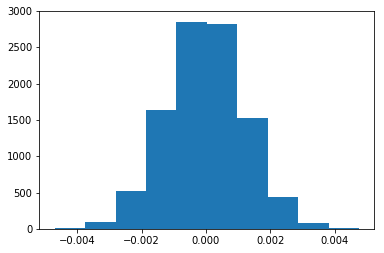

In [69]:
plt.hist(p_diffs);

j. The proportion of the **p_diffs** that are greater than the actual difference observed in **ab_data.csv**

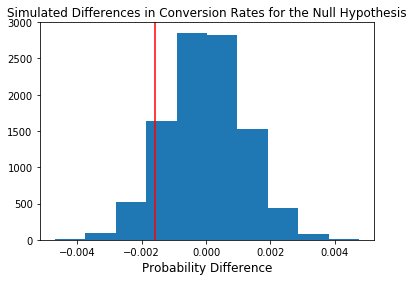

In [105]:
control = df2[df2['group'] == 'control']['converted'].mean()
treatment = df2[df2['group'] == 'treatment']['converted'].mean()
obs_diff = treatment - control
plt.hist(p_diffs);
plt.title("Simulated Differences in Conversion Rates for the Null Hypothesis", fontsize=12)
plt.xlabel("Probability Difference", fontsize=12)
plt.axvline(x=obs_diff, color='red');

In [72]:
(p_diffs > obs_diff).mean()

0.90149999999999997

**P-value is computed (in this case it is the probability of not observing any difference between convertion rates of control and treatment groups given the null hypothesis is true).**

**The p-value which came out to be 0.9 which is higher than 0.05 (agreed level of 5% chance of committing a Type I error if the null is true)tells us that it is not statistically significant an indicates strong evidence for null hypothesis. So, we fail to reject the null hypothesis.**

l. Now, calculating the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [77]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" & converted == 1')['converted'].count()
convert_new = df2.query('group == "treatment" & converted == 1')['converted'].count()
n_old = df2[df2['group']=='control'].shape[0]
n_new = df2[df2['group']=='treatment'].shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Using `stats.proportions_ztest` to compute out test statistic and p-value.  

In [107]:
z_score, p_value =sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value 

(-1.3109241984234394, 0.90505831275902449)

**A negative z-score (-1.310) and the value of p-value (0.90) suggests that we should fail to reject the null hypothesis. It agrees with the findings in parts j. and k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result that we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**We will be performing Logistic Regression**

a. The goal is to use **statsmodels** to fit the regression model to see if there is a significant difference in conversion based on which page a customer receives. However, we first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Adding an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [80]:
df2['intercept']=1
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


b. Using **statsmodels** to instantiate our regression model on the two columns we created in part a., then we will fit the model using the two columns we created in part **a.** to predict whether or not an individual converts. 

In [86]:
import statsmodels.api as sm

lm=sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results=lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


c. Providing the summary of our model below.

In [89]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 17 May 2020   Pseudo R-squ.:               8.077e-06
Time:                        15:25:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**The logistic regression determines only two possible outcomes. If the new page is equal to the old page or different.**

$H_{0}$: **$p_{new}$** - $p_{old}$ $=$ 0 and  $H_{1}$: **$p_{new}$** - $p_{old}$ $!=$ 0

**The p-value calculated here is 0.190. 0.190 is still greater than 0.05 (our $\alpha$), so we still cannot reject our null hypothesis.**

**We could consider adding some features like nationality, age, gender or specific cultural behavior of the users to our regression model. Adding additional information about users could reveal the hidden value of the new page for specific group of the users.**

d. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. We will need to read in the **countries.csv** dataset and merge together our datasets on the appropriate rows. 

In [91]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0


In [93]:
df_new[['ca', 'uk', 'us']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,ca,uk,us
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0


In [95]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'uk', 'us']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 17 May 2020   Pseudo R-squ.:               1.521e-05
Time:                        15:47:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
uk             0.0507      0.028      1.786      0.074      -0.005       0.106
us             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

**The p-values for the countries are above 0.05, so again we cannot reject the null hypothesis. Countries do not influence significantly differences in the conversion rates.**

e. Now we would look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Providing the summary results, and the conclusions based on the results.

In [96]:
df_new['us_page'] = df_new['us'] * df_new['ab_page']
df_new['uk_page'] = df_new['uk'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,ca,uk,us,us_page,uk_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0,0,1


In [98]:
# Fit Your Linear Model And Obtain the Results
lm = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'us', 'uk', 'us_page', 'uk_page']])
result = lm.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 17 May 2020   Pseudo R-squ.:               3.482e-05
Time:                        15:49:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
us             0.0175      0.038      0.465      0.642      -0.056       0.091
uk             0.0118      0.040      0.296      0.767      -0.066       0.090
us_page        0.0469      0.054      0.872      0.383      -0.059       0.152
uk_page        0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

<a id='conclusion'></a>

## Conclusion

**None of the variables have significant p-values. Therefore, we will fail to reject the null hypothesis and we conclude that there is not sufficient evidence to suggest that there is any relation between country and page received that will predict whether a user converts or not.**

**Based on the available information, we do not have sufficient evidence to suggest that the new page results in more conversions than the old page.**

**Although there could be other variables which could result in rejecting our null hypothesis (and that would require additional resources/money and time).**

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])